# Introduction

In this notebook, we will train a neural network using Tensorflow to classify animal images.

We will be using the Animal data in this notebook
[dataset](https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import numpy as np
# import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random

# Load the labels

In [3]:
animals_dataset = ["cats","dogs","panda"]

# Load the Data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

batch_size= 16
data_dir = "data/animals/"
img_height = 32
img_width = 55
# Rescaling the input image as well as Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes = animals_dataset,
    subset='training',
    shuffle=True) # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes = animals_dataset,
    subset='validation',
    shuffle=True) # set as validation data

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# Visualising samples from training set

In [5]:
training_samples, labels = train_generator.next()

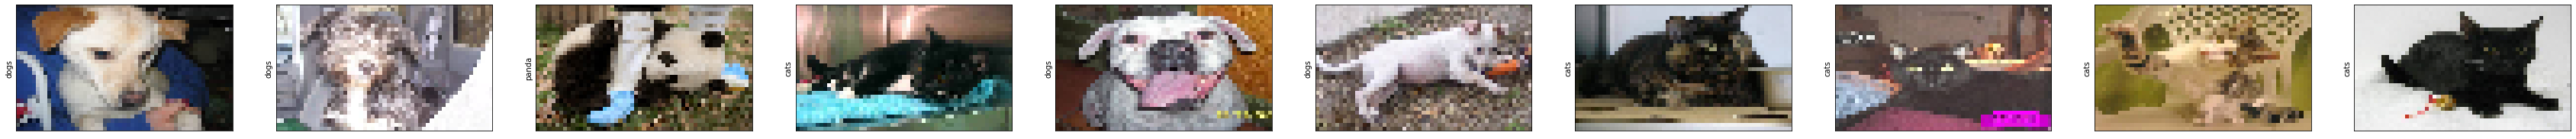

In [6]:
plt.figure(figsize=(60, 60))

for i in range(10):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    image = training_samples[i]
    plt.imshow(image, cmap=plt.cm.binary)
    label = int(np.argmax(labels[i]))
    plt.ylabel(animals_dataset[label])
plt.show()

# Building the model

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D

model = Sequential()

model.add(Convolution2D(32, (2, 2), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 31, 54, 32)        416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 26, 32)        4128      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 13, 32)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 7, 13, 32)         0         
                                                                 
 flatten_1 (Flatten)         (None, 2912)             

* **Flatten layer** converts the 2D array to a 1D array (28 x 28 = 784 dimensions)
* **Dense layer** deeply connects with its preceding layer, i.e. all neurons of the layer are connected to every neuron of its preceding layer. Neurons in the deep layer receiv output from every neuron of its preceding layer, where neurons of the dense layer perform matrix-vector multiplication.
* One Dense layer with **128 nodes**
* One Dense layer with **10 nodes** which returns an array of length 10. Each node contains a score indicating the current images' probability of belong to each of the classes 

## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [19]:
from keras.callbacks import ModelCheckpoint, TensorBoard
import datetime

filepath = 'models/animal-image-classification.h5'
checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1, save_best_only=True,mode='max')

log_dir = "logs/fit/animal-classifier" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [checkpoint, tensorboard_callback]

model.fit(train_generator,
          validation_data=validation_generator,
          epochs=50,
          verbose=1,
          callbacks=callbacks)

Epoch 1/50
149/150 [============================>.] - ETA: 0s - loss: 1.4852 - accuracy: 0.5461
Epoch 1: val_accuracy improved from -inf to 0.59333, saving model to models\animal-image-classification.h5
150/150 [==============================] - 5s 29ms/step - loss: 1.4838 - accuracy: 0.5462 - val_loss: 0.9907 - val_accuracy: 0.5933
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.8864 - accuracy: 0.6379
Epoch 2: val_accuracy improved from 0.59333 to 0.62833, saving model to models\animal-image-classification.h5
150/150 [==============================] - 4s 29ms/step - loss: 0.8864 - accuracy: 0.6379 - val_loss: 0.8359 - val_accuracy: 0.6283
Epoch 3/50
149/150 [============================>.] - ETA: 0s - loss: 0.8091 - accuracy: 0.6581
Epoch 3: val_accuracy did not improve from 0.62833
150/150 [==============================] - 4s 28ms/step - loss: 0.8084 - accuracy: 0.6583 - val_loss: 0.8837 - val_accuracy: 0.6050
Epoch 4/50
148/150 [============================

149/150 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.7672
Epoch 28: val_accuracy did not improve from 0.74000
150/150 [==============================] - 4s 28ms/step - loss: 0.6847 - accuracy: 0.7671 - val_loss: 0.8101 - val_accuracy: 0.7167
Epoch 29/50
149/150 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.7777
Epoch 29: val_accuracy did not improve from 0.74000
150/150 [==============================] - 4s 29ms/step - loss: 0.6763 - accuracy: 0.7771 - val_loss: 0.8151 - val_accuracy: 0.7267
Epoch 30/50
149/150 [============================>.] - ETA: 0s - loss: 0.6885 - accuracy: 0.7768
Epoch 30: val_accuracy did not improve from 0.74000
150/150 [==============================] - 4s 28ms/step - loss: 0.6874 - accuracy: 0.7771 - val_loss: 0.8415 - val_accuracy: 0.7300
Epoch 31/50
150/150 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.7967
Epoch 31: val_accuracy did not improve from 0.74000
150/150 [===========

## Evaluate

In [20]:
loaded_model = tf.keras.models.load_model(filepath)

In [21]:
test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
print("Validation Loss: {}, Validation Accuracy: {}".format(test_loss, test_accuracy))

38/38 [==============================] - 1s 19ms/step - loss: 0.8147 - accuracy: 0.7700
Validation Loss: 0.814729630947113, Validation Accuracy: 0.7699999809265137


# Testing

In [22]:
from tensorflow.keras import layers

test_ds = tf.keras.utils.image_dataset_from_directory(
    'data\images',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 3 files belonging to 3 classes.


In [23]:
def plot_image(i, predictions_array, true_label, img):
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  color = 'green' if predicted_label == true_label else 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(animals_dataset[predicted_label],
                                100*np.max(predictions_array),
                                animals_dataset[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    plt.xticks(range(3), animals_dataset)
    plt.yticks([])
    thisplot = plt.bar(range(3), predictions_array, color="#7d4646")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

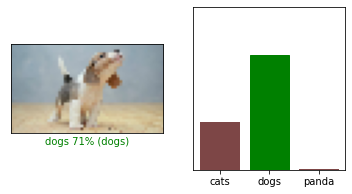

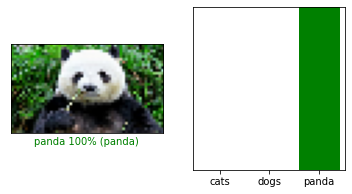

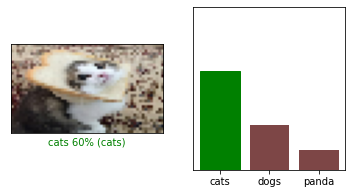

In [24]:
for images, labels in normalized_ds.take(1):
    for i in range(3):
        image = images[i]
        label = labels[i]
        image_batch = tf.expand_dims(image, [0])
        prediction = loaded_model.predict(image_batch)

        # Plotting
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plot_image(i, prediction[0], label, image)
        plt.subplot(1,2,2)
        plot_value_array(i, prediction[0],  label)
        plt.show()